# Capitulo 10 - Aprendizado Profundo para Séries Temporais

In [1]:
import keras  
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

* Não se exige estacionaridade.
* Desaparee a necessidade de desevolver uma hipotese sobre a dinamica subjacente do sistema.

> Apesar de não exigir estacionariedade , na pratica, não se ajustam bem a dados com tedencias

### Construindo um pipeline de treinamento

In [2]:
data = pd.read_csv('dataset/electricity.txt', sep=',', header=None, names=list(range(1, 322)))

In [3]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,312,313,314,315,316,317,318,319,320,321
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [4]:
data.shape

(26304, 321)

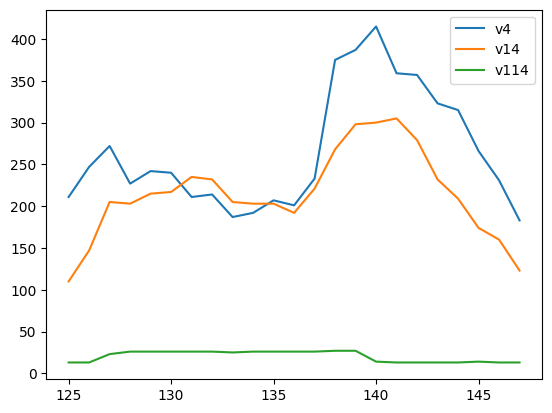

In [5]:
plt.plot(data.iloc[125:148, 4], label='v4')
plt.plot(data.iloc[125:148, 14], label='v14')
plt.plot(data.iloc[125:148, 114], label='v114')
plt.legend()
plt.show()

> Como se trata de dados por hora, plotamos 24 pontos de dados , assim temos o valor de um dia interio de dados, acima

plotando a semana

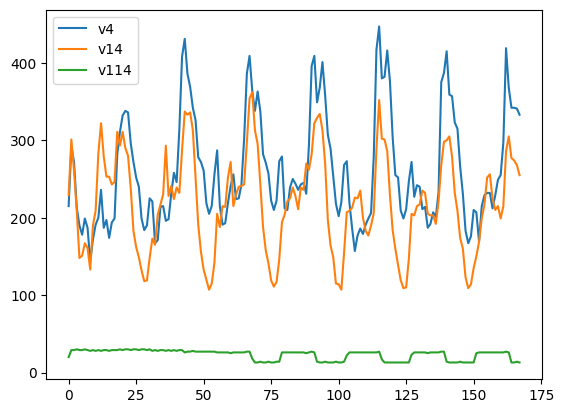

In [6]:
plt.plot(data.iloc[:24*7, 4], label='v4')
plt.plot(data.iloc[:24*7, 14], label='v14')
plt.plot(data.iloc[:24*7, 114], label='v114')
plt.legend()
plt.show()

Ainda que pudessemos predizer os valores absolutos dos dados como nossa tecnica de previsão, isso ja foi feito em artigos academicos e postagens de blogs.
Em vez disso, vamos predizer a diferença dos dados... Predizer a diferença em vez dos valores totais de uma série temporal costuma ser desafiafor pq os dados são mais ruidosos.

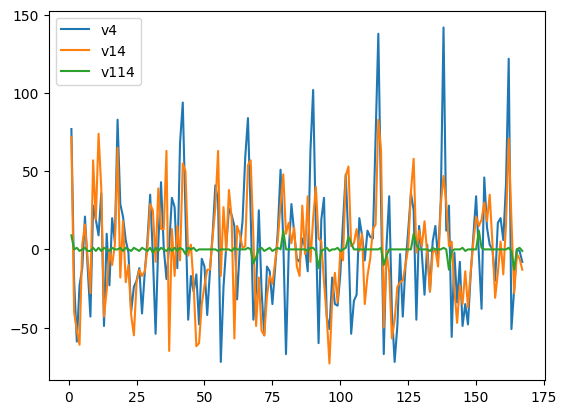

In [7]:
plt.plot(data.iloc[:24*7, 4].diff(), label='v4')
plt.plot(data.iloc[:24*7, 14].diff(), label='v14')
plt.plot(data.iloc[:24*7, 114].diff(), label='v114')
plt.legend()
plt.show()

In [8]:
data.diff().to_csv('dataset/electricity_diff.txt', sep=',', index=False)

> Se fossemos excutar modelos tradicionais, modelo de ml **séria necessario fazer uma boa analise desses pontos para examinar as correlações entre diferentes locais consumidosres de energia eletrica no conj. de dados**
> Avaliar a estacionariedade se houve desvio ao longo do tempo no dados.

> **É necessario fazer essa coisa no aprendizdo profundo, de modo voce consiga avaliar os modelos apropriados para o conj de dados e também determinar as expectivativas**

### Etapas de uma pipeline de treinamento

* Facilitação a parimetrizacao do codigo
* Extração dos dados para memoria e o devido pre-processamento
* Modelagem adequada dos dados no formato esperado
* Criação do grafo que usa esse iteradores para saber qual formato de dados esperar.
* definir parametros do modelo
* estabelecimento de uma tipo de sistema de registro de dados para seus peso e para seus resultados de epoca para epoca

In [9]:
#%%writefile capitulo_10.py
from math import floor 

# para arquivamento
import os 
import argparse

# modelo profundo

import keras 

# para processamento
import numpy as np 
import pandas as pd 

## relatorio cunstomizado
import perf_tool

## alguns hiperparemtros que não ajustamos por meio da entradas de linhas de comando

DATA_SEGMENT = {
    'tr' : 0.6,  "va": 0.2, 'tst':0.2
}

THRESHOLD_EPOCHS = 5
THRESHOLD_COR    = 0.0005


## Definindo parser

parser = argparse.ArgumentParser()


## Data shaping

### janela
parser.add_argument('--win', type=int, default=24*7)
parser.add_argument('--h', type=int, default=3)

## Especificação do modelo 
parser.add_argument('--model', type=str, default='rnn_model')

### conponent da CNN
parser.add_argument('--sz-filt', type=str, default=8)
parser.add_argument('--n-filt', type=int, default=10)

### conponent da RNN
parser.add_argument('--rnn-units',  type=int, default=10)

## Detalhes do treinamento

parser.add_argument('--n_batch', type=int, default=1024)
parser.add_argument('--learning_rate', type=float, default=0.0001)
parser.add_argument('--n_epochs', type=float, default=30)
parser.add_argument('--drop', type=float, default=0.2)

## Repositorio
parser.add_argument('--data-dir', type=str, default='../models')
parser.add_argument('--save-dir', type=str, default=None)


_StoreAction(option_strings=['--save-dir'], dest='save_dir', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

### Preparando nossos dados de entrada

#### Data shaping


 🔹 `nt`

* Representa o **número de passos de tempo** (*number of timesteps*) que a RNN vai olhar de uma vez.
* Também chamado de **janela temporal**.
* Exemplo:

  * Se você tem uma série diária e define `nt = 10`, a RNN recebe **10 dias passados** como entrada para prever o próximo.
  * É a dimensão da sequência no eixo do tempo.

---

🔹 `ntc`

* Representa o **formato de entrada** da RNN:

  * **n** → número de amostras (*batch size*)
  * **t** → número de passos de tempo (*timesteps*)
  * **c** → número de características (*features*) por passo

Ou seja, **`(n, t, c)` = (amostras, timesteps, features)**.

Exemplo:

* Você tem 1000 amostras (n = 1000),
* Cada amostra é uma sequência de 10 dias (t = 10),
* Cada dia tem 3 variáveis (c = 3, por ex. temperatura, pressão e umidade).

A entrada para a RNN será **`ntc = (1000, 10, 3)`**.


> Nenhuma dessas representações tem acuracia maior do que a outra,

In [37]:
def prepare_data(data_dir, win, h, model_name='fc_model', num_features=321):
    data = pd.read_csv(
        os.path.join(data_dir, 'electricity_diff.txt'), sep=',').dropna()
    
    x = data.values.astype('float32')
    x = x[:, :num_features+1]
    # Normalizando os dados
    x = (x - np.mean(x, axis=0, dtype=np.float32)) / np.std(x, axis=0, dtype=np.float32)

    if model_name == 'fc_model': ## NC data
        X = np.hstack([x[1:-h], x[0:-(h+1)]], dtype=np.float32)
        y = x[h:]

        return X, y
    else: ## TNC data
        X = np.zeros((x.shape[0] - win - h, win, x.shape[1]),  dtype=np.float32)
        y = np.zeros((x.shape[0] - win - h, x.shape[1]),  dtype=np.float32)

        for i in range(win, x.shape[0] - h):
            X[i-win] = x[(i - win):i, :]   # janela de tamanho 'win'
            y[i-win] = x[i + h - 1, :]     # target deslocado por h

        return X, y

In [45]:
def prepare_iter(X, y):


    n_train = int(y.shape[0] * DATA_SEGMENT['tr'])
    n_validation = int(y.shape[0] * DATA_SEGMENT['va'])

    xtrain, xvalid, xtest = (
        X[:n_train],
        X[n_train:n_train + n_validation],
        X[n_train + n_validation:]
    )

    ytrain, yvalid, ytest = (
        y[:n_train],
        y[n_train:n_train + n_validation],
        y[n_train + n_validation:]
    )

    return (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest)

In [39]:
X, y = prepare_data('dataset', 24*7, 3, num_features=4)

In [40]:
(xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = prepare_iter(X, y, 24*7, 3)

#### Definindo parametro

### Reder neural simples

In [41]:
def rna_model(input_shape, output_shape):
    return keras.models.Sequential([
        keras.layers.Flatten(input_shape=(input_shape)),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(output_shape)
    ])

In [62]:
def fit_(model, xtrain, ytrain, xvalid, yvalid, n_epochs=30):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
        loss='mse'
    )
    history = model.fit(
        xtrain, ytrain, 
        epochs=n_epochs, 
        validation_data=(xvalid, yvalid)
    )

    return history, model

### Mecanimos de atenção

Atençao é a ideia de uma arquiterura de rede neural forneça uma meacanimos para um modelo aprender quais informações são importatntes e quando. isso é feito por meio de pesos de atenção,ajustados a cada intervalo de tempo com um objetivo de ser o modelo aprenda combinar informações de diferentes intervalos.

## CNN

Uso :
* Estabelecer um impressão digital para o historio de navegação  de uma usuario na internt, o que ajuda a detectar atividades de navegação
* Gerar predição de trafec com base nos registros anteriores de varios lovais em um grande cidade

### Rede convolucional simples

In [63]:
X, y = prepare_data('dataset', 24*7, 3,'a', num_features=4)

(xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = prepare_iter(X, y)

In [64]:
def cnn_model(input_shape, output_shape):
    return keras.models.Sequential([
        keras.layers.Conv1D(10, 3, activation='relu', input_shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dense(output_shape)
    ])

In [65]:
xtrain.shape

(15679, 168, 5)

In [66]:
cnn_simples = cnn_model(xtrain.shape[1:], 5)
cnn_simples.summary()

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-analise-pratica-series-temporais\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 166, 10)        │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1660)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1660)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 20)             │        33,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,485 (130.80 KB)

 Trainable params: 33,485 (130.80 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
history, model = fit_(cnn_simples, xtrain, ytrain, xvalid, yvalid, n_epochs=10)

Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.1200 - val_loss: 0.5543
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0007 - val_loss: 0.5136
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9578 - val_loss: 0.4892
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9252 - val_loss: 0.4709
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8961 - val_loss: 0.4593
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8720 - val_loss: 0.4428
Epoch 7/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8509 - val_loss: 0.4355
Epoch 8/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8332 - val_loss: 0.4292
Epoch 9/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8179 - val_loss: 0.4280
Epoch 10/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8023 - val_loss: 0.4237


<Axes: >

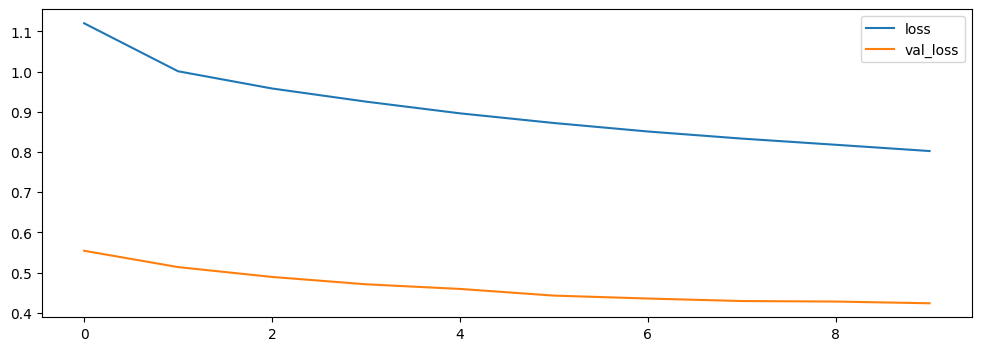

In [69]:
pd.DataFrame(history.history).plot(figsize=(12, 4))

In [71]:
pred = model.predict(xtest)

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


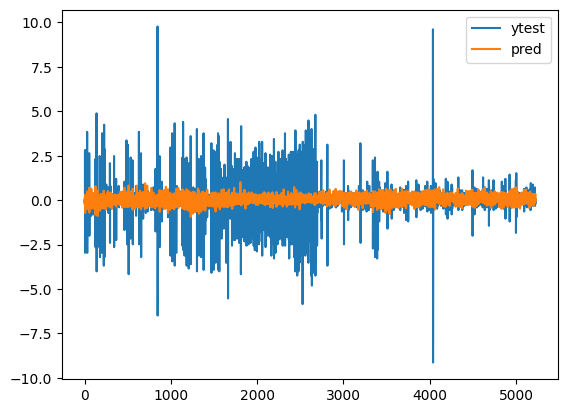

In [75]:
plt.plot(ytest[:,0], label='ytest')
plt.plot(pred[:,0], label='pred')
plt.legend()